# Table of Contents
 <p>

In [11]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import epistasis as epi
import tissue_enrichment_analysis as tea
import scipy

from matplotlib import rc

import os
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})


%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
strains =['ps4187', 'ps4087', 'ps4176', 'ew15', 'mt21245', 'mt4866','n2731', 'n2376', 'n767', 'n2731-n767', 'tm1489',
          'n3809', 'n3917', 'n745', 'n767-tm1489', 'n2731-tm1489',
          'ia4', 'ok1402', 'ok161', 'sa307', 'sa307-ok161', 'sa307-ia4',
          'q71']

strain_dict = {}
for i, g in enumerate(strains):
    strain_dict[g] = i

In [3]:
q = 0.1

In [4]:
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep=' ', comment='#')
tidy = pd.read_csv('../input/quantifications.csv')

In [5]:
gf_size = len(tidy[(tidy.qval < q) & (tidy.strain == 'mt21245')].ens_gene.unique())
lf_size = len(tidy[(tidy.qval < q) & (tidy.strain == 'mt4866')].ens_gene.unique())

print('Loss of function DE genes: {0}'.format(lf_size))
print('Gain of function DE genes: {0}'.format(gf_size))

Loss of function DE genes: 857
Gain of function DE genes: 3021


In [6]:
overlap = epi.find_overlap(['mt21245', 'mt4866'], tidy)
print('{0}, {1:.2g}%'.format(len(overlap), 100*len(overlap)/lf_size))

269, 31%


In [7]:
def get_x_and_y_from_df(overlap, df, strain1, strain2):
    x = tidy[(tidy.strain==strain1) & (tidy.target_id.isin(overlap))].b.values
    y = tidy[(tidy.strain==strain2) & (tidy.target_id.isin(overlap))].b.values

    se_x = tidy[(tidy.strain==strain1) & (tidy.target_id.isin(overlap))].se_b.values
    se_y = tidy[(tidy.strain==strain2) & (tidy.target_id.isin(overlap))].se_b.values
    
    return x, y, se_x, se_y

In [9]:
def density_color(x, y):
    points = np.vstack([x, y])
    z = scipy.stats.gaussian_kde(points)(points)
    return z

1.08366694946


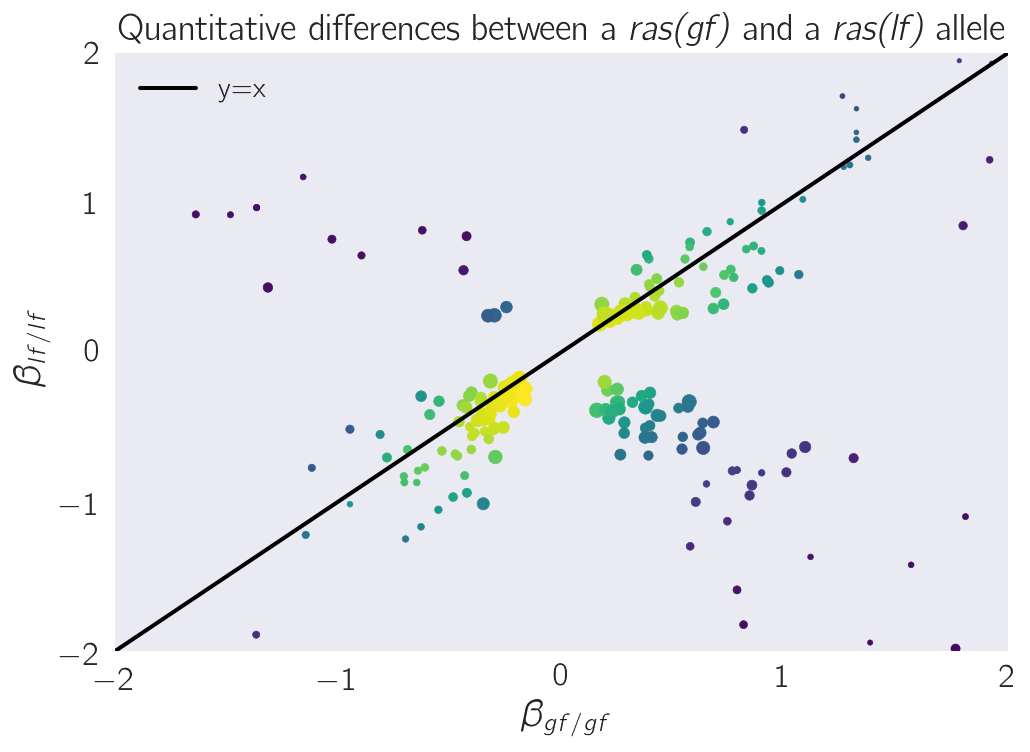

In [34]:
x, y, se_x, se_y = get_x_and_y_from_df(overlap, tidy, 'mt21245', 'mt4866')

odr = epi.perform_odr(x, y, se_x, se_y, beta0=[0.5])

z = density_color(x, y)
plt.scatter(x, y, s=3/se_y, alpha=1, c=z, cmap='viridis')
plt.plot([-2, 2], [-2,2], 'k', ls='-', label='y=x')

plt.legend()

plt.xlabel(r'$\beta_{gf/gf}$')
plt.ylabel(r'$\beta_{lf/lf}$')

plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.xticks([-2, -1, 0, 1, 2])
plt.yticks([-2, -1, 0, 1, 2])

plt.title('Quantitative differences between a \emph{ras(gf)} and a \emph{ras(lf)} allele')

plt.savefig('../output/ras_allele_comparison.svg', bbox_inches='tight')
print(odr.beta[0])

In [16]:
lf = tidy[(tidy.strain == 'mt21245') & (tidy.target_id.isin(overlap))].copy()
gf = tidy[(tidy.strain == 'mt4866') & (tidy.target_id.isin(overlap))].copy()

lf['standardized_b'] = lf.b.values/gf.b.values

Slope of this line is -1


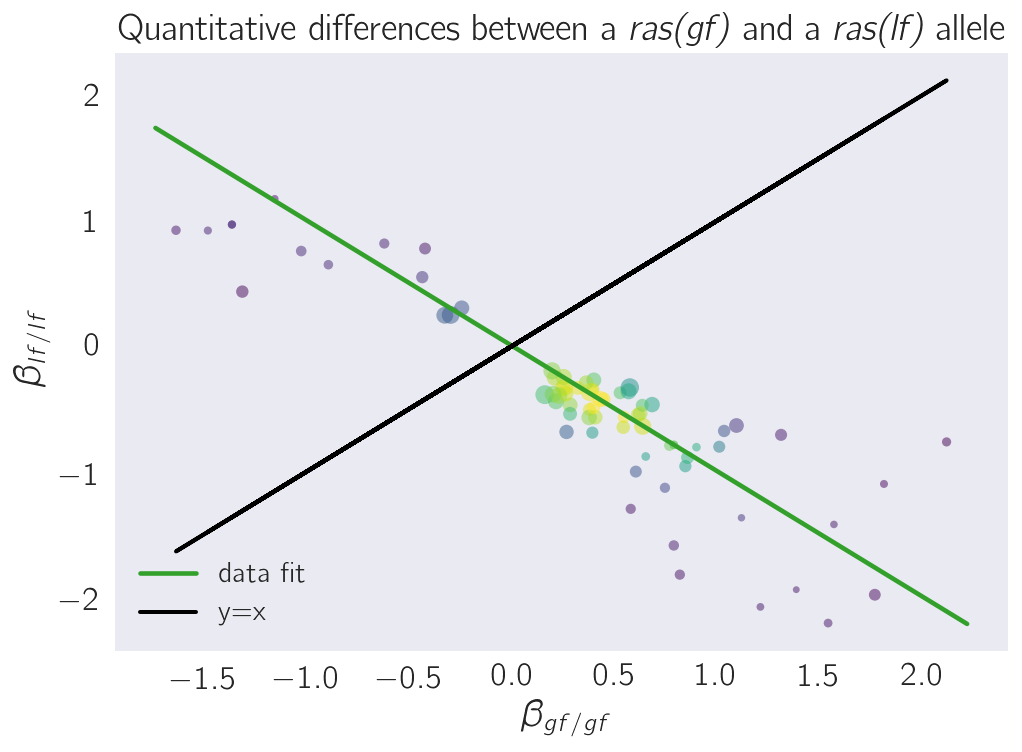

In [36]:
anticorr = lf[lf.standardized_b < 0].target_id.unique()

x, y, se_x, se_y = get_x_and_y_from_df(anticorr, tidy, 'mt21245', 'mt4866')

odr = epi.perform_odr(x, y, se_x, se_y, beta0=[0.5])
epi.epiplot(x, y, se_y, s0=5, beta=odr.beta[0])

plt.plot(x, x, 'k', ls='-', label='y=x')
plt.legend()

plt.xlabel(r'$\beta_{gf/gf}$')
plt.ylabel(r'$\beta_{lf/lf}$')

plt.title('Quantitative differences between a \emph{ras(gf)} and a \emph{ras(lf)} allele')

print('Slope of this line is {0:.3g}'.format(odr.beta[0]))

Slope of this line is 1.03


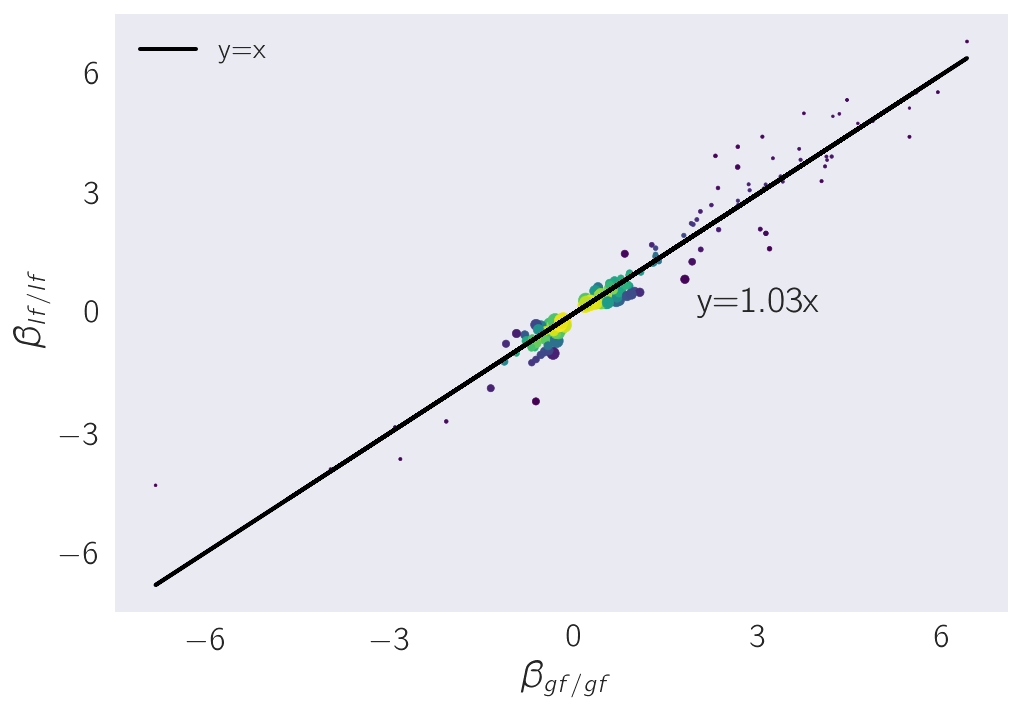

In [35]:
corr = lf[lf.standardized_b > 0].target_id.unique()

x, y, se_x, se_y = get_x_and_y_from_df(corr, tidy, 'mt21245', 'mt4866')

odr = epi.perform_odr(x, y, se_x, se_y, beta0=[0.5])
z = density_color(x, y)

plt.scatter(x, y, s=3/se_y, alpha=1, c=z, cmap='viridis')
plt.plot(x, x, 'k', ls='-', label='y=x')
plt.annotate('y={0:.3g}x'.format(odr.beta[0]), (2, 0), fontsize=18)

plt.legend()
plt.xlabel(r'$\beta_{gf/gf}$')
plt.ylabel(r'$\beta_{lf/lf}$')

plt.xticks([-6, -3, 0, 3, 6])
plt.yticks([-6, -3, 0, 3, 6])

print('Slope of this line is {0:.3g}'.format(odr.beta[0]))
plt.savefig('../output/correlated_ras_genes.svg', bbox_inches='tight')


In [13]:
tissue = tea.fetch_dictionary('tissue')
pheno = tea.fetch_dictionary('phenotype')
go = tea.fetch_dictionary('go')